In [5]:
import torch
from models.resnet import Resnet
from file_utils import read_json
from models.task import get_task
from models.decoder import get_decoder

args = {}
args_path = "/home/luiz.decker/code/DepthTasks/logs/resnet_depth_e-3_nyu/_22/args.json"
args.update(read_json(args_path))

if "tasks" in args:
    task_list = []
    for task in args["tasks"]:
        Task = get_task(task["type"])
        Decoder = get_decoder(task["decoder"]["type"])

        _task = Task(
            name=task["name"],
            decoder=Decoder,
            features=task["features"],
            channels=task["channels"],
            mask_feature=task.get("mask_feature"),
            decoder_args=task["decoder"]["args"],
            train_on_disparity=task.get("train_on_disparity", False),
        )

        task_list.append(_task)
    args["tasks"] = task_list


modelpath = "/home/luiz.decker/code/DepthTasks/logs/resnet_depth_e-3_nyu/_22/lightning_logs/version_0/checkpoints/epoch=99-step=2500.ckpt"

model_weights = torch.load(modelpath)

model = Resnet(tasks=args['tasks'], features=args['features'],pretrained_encoder=False)

model.load_state_dict(model_weights['state_dict'])

<All keys matched successfully>

In [10]:
from datasets.nyu import NYUDepthV2
args['split_json'] = "/home/luiz.decker/code/DepthTasks/configs/nyu.json"

val_ds = NYUDepthV2(split='validation', **args)

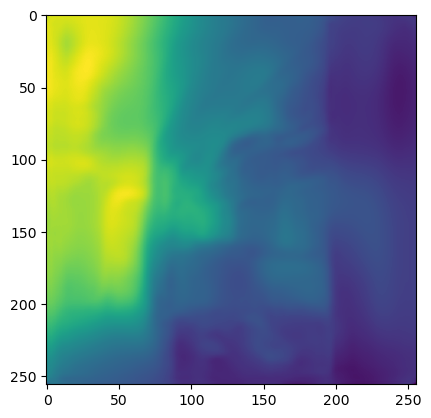

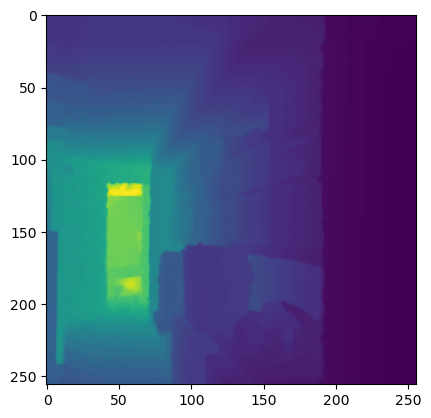

In [43]:
import matplotlib.pyplot as plt

idx = 5
img, depth = val_ds[idx]
pred = model(img.unsqueeze(dim=1)).detach().numpy()

plt.imshow(pred.squeeze(axis=(0,1)).swapaxes(0,2).swapaxes(0,1))
plt.show()
plt.imshow(depth.squeeze(dim=(0)).swapaxes(0,2).swapaxes(0,1))
plt.show()

In [53]:
from torch import nn
from torchgeometry.losses import SSIM

class CombinedLoss(nn.Module):
    def __init__(self) -> None:
        super().__init__()

    def forward(self,a,b):
        huber = nn.functional.huber_loss(a,b)
        ssim = SSIM(11,reduction='mean')(a,b)
        return huber + ssim
    
CombinedLoss()(depth,depth)

tensor(0.)